In [1]:
import os
import pandas as pd
import numpy as np

import math
from datetime import datetime

In [2]:
#Preprocessing parameters
raw_data_folder='data_raw\converted_saves-continous1\\'
lookback=2
output_folder='Feedforward\data\data_preprocessed\\'

In [3]:
#Posttion estimation

def pos_x_est(t0, t1, t, r=257.5):
    return math.cos((t-t0)/(t1-t0)*(math.pi/2))*r

def pos_y_est(t0, t1, t, r=257.5):
    return math.sin((t-t0)/(t1-t0)*(math.pi/2))*r

In [4]:
filenames = os.listdir(raw_data_folder) #Location of data files
df = pd.DataFrame()

for file in filenames:
    df_new = pd.read_csv(raw_data_folder + file) #Read data file
    df_new=df_new[df_new.index<len(df_new.index)-1] #Drop false reading
    df_new['t'] = df_new.apply(lambda x: int((x['TIME1']+x['TIME2'])/2), axis=1) #Use single timestamp for each data
    df_new.drop(columns=['TIME1', 'TIME2'], inplace=True) #Drop unnessessary columns
    
    #Adding position estimates
    t0=df_new.at[0, 't']
    t1=df_new.at[len(df_new.index)-1, 't']
    
    df_new["X_pos"]=df_new.apply(lambda x: pos_x_est(t0, t1, x['t']), axis=1)
    df_new["Y_pos"]=df_new.apply(lambda x: pos_y_est(t0, t1, x['t']), axis=1)
    
    #Adding previous measurements
    lookback=2
    
    df_temp = pd.DataFrame()
    df_temp= pd.concat([df_temp,df_new], axis=1)
    
    for i in range(lookback):
        df_cpy=df_temp[df_temp.index > i]
        df_cpy.reset_index(drop=True, inplace=True)
        df_cpy=df_cpy.rename(columns={"ACC_X": "ACC_X_" + str(i+1),
                           "ACC_Y": "ACC_Y"+ str(i+1),
                           "ACC_Z": "ACC_Z"+ str(i+1),
                           "QUAT_W": "QUAT_W"+ str(i+1),
                           "QUAT_X": "QUAT_X"+ str(i+1),
                           "QUAT_Y": "QUAT_Y"+ str(i+1),
                           "QUAT_Z": "QUAT_Z"+ str(i+1),
                           "t": "t"+ str(i+1),
                           "X_pos": "X_pos"+ str(i+1),
                           "Y_pos": "Y_pos"+ str(i+1)})
        
        df_new = pd.concat([df_new,df_cpy], axis=1)
        
        dtcol='dt'+ str(i+1)
        tcol='t'+ str(i+1)
            
        if i==0:            
            df_new[dtcol]=df_new[tcol]-df_new['t']
        else:
            t2col='t'+ str(i)
            df_new[dtcol]=df_new[tcol]-df_new[t2col]

    
    del df_temp
    
    for i in range(1,lookback+1):  #Drop unnessessary columns
            df_new.drop(columns=['t'+ str(i)], inplace=True)
        
    
    df_new = df_new.dropna()
    df = df.append(df_new, ignore_index=True)

del df_new
df=df.sort_values(by=['t'])
df.reset_index(drop=True, inplace=True)
df.drop(columns=['t'], inplace=True) #Drop unnessessary columns
print("Data shape"+ str(df.shape))

output_name="preprocessed_" + datetime.now().strftime("%Y-%m-%d_%H-%M-%S") + "_lookback_" + str(lookback)+'.csv'

df.to_csv(output_folder + output_name, index=False)
print("Data saved to:\n" +output_folder+ output_name)
del df


Data shape(25509, 29)
Data saved to:
data\data_preprocessed\preprocessed_2021-03-19_13-53-24_lookback_2.csv


In [9]:
#Checking output data
df_readback = pd.read_csv(output_folder+ output_name) #Read back written data
print("Data shape"+ str(df_readback.shape))
df_readback

Data shape(25509, 29)


ACC_X  ACC_Y  ACC_Z    QUAT_W    QUAT_X    QUAT_Y    QUAT_Z  \
0       4.27   4.38   0.04  0.710760  0.005249  0.703374  0.007568   
1       2.00  -0.02  -2.46  0.711246  0.004639  0.702884  0.007874   
2      -2.89   2.66  -0.17  0.711430  0.004334  0.702702  0.007568   
3       0.23   1.67   0.46  0.711430  0.004334  0.702702  0.007568   
4      -1.82   0.00   0.70  0.711557  0.004517  0.702585  0.006409   
...      ...    ...    ...       ...       ...       ...       ...   
25504  -0.56  -0.52   0.40 -0.641554 -0.486528 -0.593042  0.000936   
25505   0.97  -1.42   0.79 -0.640064 -0.490035 -0.591749  0.004082   
25506   0.97  -1.42   0.79 -0.638885 -0.494074 -0.589631  0.007237   
25507  -0.54   0.61   1.64 -0.638885 -0.494074 -0.589631  0.007237   
25508   0.96  -1.21  -2.06 -0.637200 -0.497628 -0.588417  0.010334   

            X_pos       Y_pos  ACC_X_1  ...  ACC_X_2  ACC_Y2  ACC_Z2  \
0      257.500000    0.000000     2.00  ...    -2.89    2.66   -0.17   
1      257.490794    2.177356    -2.89  ...     0.23    1.67    0.46   
2      257.461737    4.438902     0.23  ...    -1.82    0.00    0.70   
3      257.426504    6.151832    -1.82  ...    -1.82    0.00    0.70   
4      257.390334    7.514383    -1.82  ...     1.35    0.88    0.96   
...           ...         ...      ...  ...      ...     ...     ...   
25504   12.399929  257.201267     0.97  ...     0.97   -1.42    0.79   
25505   10.632122  257.280407     0.97  ...    -0.54    0.61    1.64   
25506    8.875480  257.346995    -0.54  ...     0.96   -1.21   -2.06   
25507    6.771339  257.410953     0.96  ...     0.78    0.25   -1.59   
25508    4.490772  257.460838     0.78  ...     0.78    0.25   -1.59   

        QUAT_W2   QUAT_X2   QUAT_Y2   QUAT_Z2        X_pos2      Y_pos2  \
0      0.711430  0.004334  0.702702  0.007568  2.574617e+02    4.438902   
1      0.711430  0.004334  0.702702  0.007568  2.574265e+02    6.151832   
2      0.711557  0.004517  0.702585  0.006409  2.573903e+02    7.514383   
3      0.711557  0.004517  0.702585  0.006409  2.573471e+02    8.871973   
4      0.711382  0.004273  0.702776  0.004883  2.572967e+02   10.230741   
...         ...       ...       ...       ...           ...         ...   
25504 -0.638885 -0.494074 -0.589631  0.007237  8.875480e+00  257.346995   
25505 -0.638885 -0.494074 -0.589631  0.007237  6.771339e+00  257.410953   
25506 -0.637200 -0.497628 -0.588417  0.010334  4.490772e+00  257.460838   
25507 -0.636226 -0.500501 -0.586975  0.013237  2.372977e+00  257.489066   
25508 -0.635082 -0.503193 -0.585825  0.016621  1.576733e-14  257.500000   

          dt2  
0      9518.0  
1      7210.0  
2      5736.0  
3      5716.0  
4      5722.0  
...       ...  
25504  5873.0  
25505  7033.0  
25506  7621.0  
25507  7076.0  
25508  7928.0  

[25509 rows x 29 columns]

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>], dtype=object)

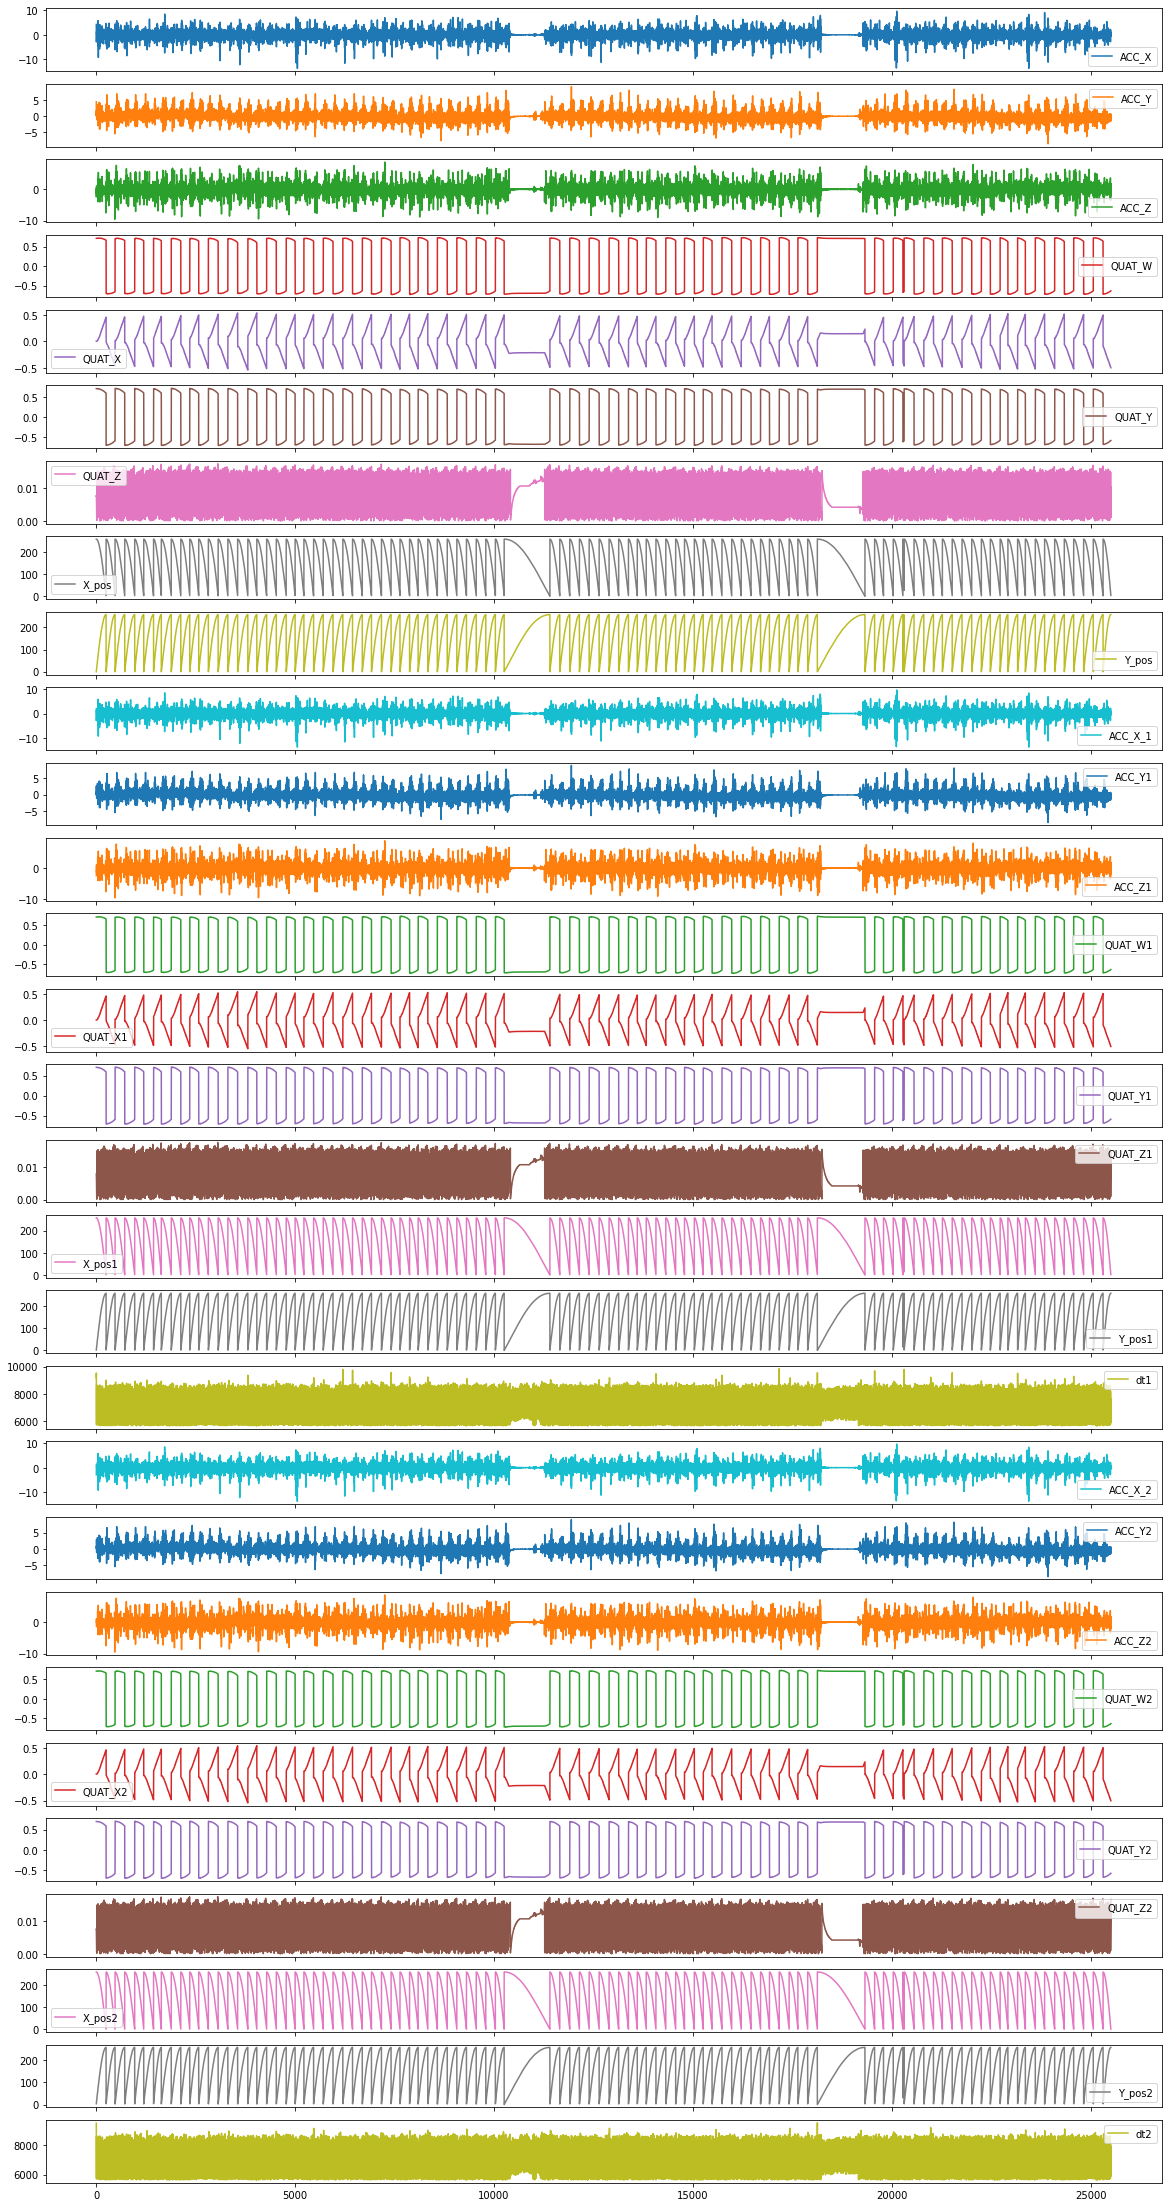

In [6]:
df_readback.plot(subplots=True, figsizes=(20,lookback*20))